Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_attention                │ (None, 64)             │            65 │
│ (SimpleAttention)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/33
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5046 - loss: 0.6938
Epoch 1: val_loss improved from None to 0.69312, saving model to best_week10_lstm_attention.keras
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 91s 29ms/step - accuracy: 0.4993 - loss: 0.6935 - val_accuracy: 0.5051 - val_loss: 0.6931
Epoch 2/33
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4952 - loss: 0.6934
Epoch 2: val_loss improved from 0.69312 to 0.69309, saving model to best_week10_lstm_attention.keras
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 47s 27ms/step - accuracy: 0.5026 - loss: 0.6933 - val_accuracy: 0.5051 - val_loss: 0.6931
Epoch 3/33
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5020 - loss: 0.6932
Epoch 3: val_loss did not improve from 0.69309
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 56s 32ms/step - accuracy: 0.5034 - loss: 0.6932 - val_accuracy: 0.5051 - val_loss: 0.6931
Epoch 4/33
1731/1732 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5082 - loss: 0.6931
Epoch 4: val_loss did not improve 

C:\Users\sudha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sudha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sudha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


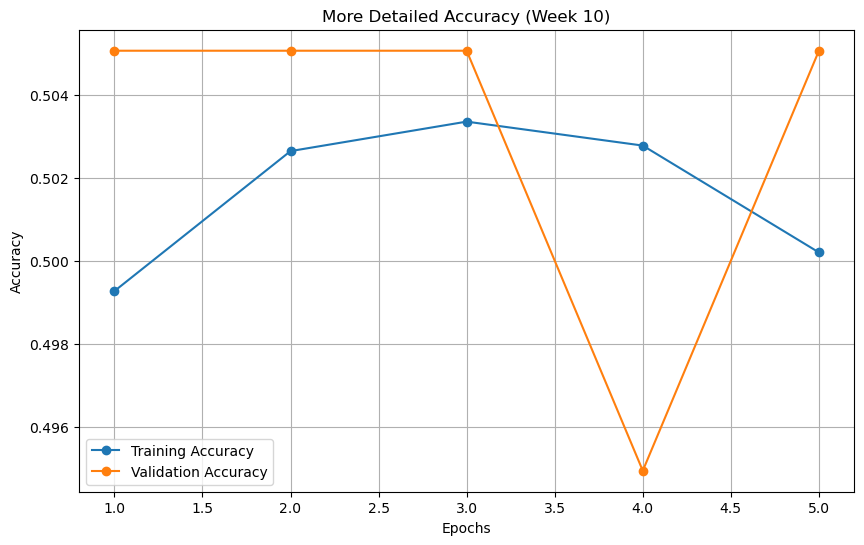

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, GlobalAveragePooling1D, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler

sid = "2421463"
Z = int(sid[-1])
EPOCHS = Z + 30
BATCH_SIZE = Z + 10

ask_path = r"C:\Users\sudha\Downloads\XAUUSD_5 Mins_Ask_2024.01.01_2024.06.30.csv"
bid_path = r"C:\Users\sudha\Downloads\XAUUSD_5 Mins_Bid_2024.01.01_2024.06.30.csv"

ask = pd.read_csv(ask_path)
bid = pd.read_csv(bid_path)

time_candidates = ["Time (UTC)", "Time", "Datetime", "Date"]
t_ask = next(c for c in time_candidates if c in ask.columns)
t_bid = next(c for c in time_candidates if c in bid.columns)

ask[t_ask] = pd.to_datetime(ask[t_ask])
bid[t_bid] = pd.to_datetime(bid[t_bid])

ask = ask.sort_values(t_ask).rename(columns={t_ask: "Time"})
bid = bid.sort_values(t_bid).rename(columns={t_bid: "Time"})

df = pd.merge_asof(ask, bid, on="Time", direction="nearest", tolerance=pd.Timedelta("5min"))
df = df.dropna().reset_index(drop=True)

df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df = df[["Time"] + numeric_cols].copy()

close_bid_col = "Close_Bid" if "Close_Bid" in df.columns else numeric_cols[0]

horizon_steps = 5
df["future_close_bid"] = df[close_bid_col].shift(-horizon_steps)
df = df.dropna().reset_index(drop=True)

df["y"] = (df["future_close_bid"] > df[close_bid_col]).astype(int)

feature_cols = [c for c in numeric_cols if c != "future_close_bid"]
X_raw = df[feature_cols].values.astype("float32")
y = df["y"].values.astype("int32")

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw).astype("float32")

seq_len = 50
M = len(df) - seq_len + 1

X = np.zeros((M, seq_len, X_scaled.shape[1]), dtype="float32")
Y = np.zeros((M,), dtype="int32")

for i in range(M):
    X[i] = X_scaled[i:i+seq_len, :]
    Y[i] = y[i+seq_len-1]

train_size = int(0.8 * M)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}

class SimpleAttention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.W = Dense(1)

    def call(self, x):
        scores = self.W(x)
        weights = tf.nn.softmax(scores, axis=1)
        context = tf.reduce_sum(x * weights, axis=1)
        return context

inp = Input(shape=(seq_len, X_train.shape[2]))
x = LSTM(64, return_sequences=True)(inp)
x = Dropout(0.2)(x)
x = SimpleAttention()(x)
x = Dense(32, activation="relu")(x)
out = Dense(1, activation="sigmoid")(x)

model = Model(inp, out)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint("best_week10_lstm_attention.keras", monitor="val_loss", save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, mc],
    class_weight=class_weight,
    verbose=1
)

y_prob = model.predict(X_test, verbose=0).reshape(-1)
y_pred = (y_prob >= 0.5).astype(int)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, acc, marker="o", label="Training Accuracy")
plt.plot(epochs_range, val_acc, marker="o", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("More Detailed Accuracy (Week 10)")
plt.legend()
plt.grid(True)
plt.show()